# 데이터 이해하기, 어떻게 분석할지 고민하기, 준비하기

In [1]:
!samtools view ../datapack/CLIP-35L33G.bam | head -6

SRR458758.23028115	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	HHGHHGE@GGHHED?GEGDG	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.23879202	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	GBGGEEAAF=CEEDEGBGG>	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.23893532	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	G@?GGE=EFBDDGGGGD@GG	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.26501547	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	IIIHIIIHIGHIIIHEHIHH	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.685997	16	chr1	3059006	0	22M	*	0	0	TTCATTTACAGAATGGAATACT	EG7:776DGGGBD<GGEBGEG@	MD:Z:22	NH:i:30	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:+
SRR458758.12045118	16	chr1	3059006	0	22M	*	0	0	TTCATTTACAGAATGGAATACT	IFGIDDIHIHEIIIIIIIIHBI	MD:Z:22	NH:i:30	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:+
samtools view: writing to standard output failed: Broken

In [2]:
# 전체 read 개수
!samtools view ../datapack/CLIP-35L33G.bam | wc -l

 38880853


* GSNAP 깃헙 readme 설명 중 sam output 에 대한 설명을 읽어보면 `XS:` tag가 splice의 strand orient를 표기한다. splice donor-acceptor 페어가 +/- strand 중 어떤 strand에 매치되는지를 표기하는 듯 하다. splice가 모호하거나 가능성이 낮다고 판단되면 XS:A:+ 혹은 XS:A:-로 표기한다고 나와있다. 일단 새로 alignment를 진행하는 일 없이 `CLIP-35L22G.bam`파일에서 작업을 시작하고 싶으므로, 이 XStag를 사용하여 분석을 진행한다.  

In [3]:
# splicing을 포함하는 read의 경우는 XStag가 어떻게 표현되는 지.
!samtools view ../datapack/CLIP-35L33G.bam | awk '$6 ~/N/ {print $0}' | grep "XS:A:+" | head -3

SRR458758.9848071	0	chr1	3610407	35	32M20939N8M2S	*	0	0	AAGCAGGTCAGGGAGCAGGAGCTGATGCAGAGGCCGAGGTAT	B8;4BBBDDDDDDBD7D4D::?BBBDDB<D=4D4D4;41:+2	MD:Z:24T6A8	NH:i:1	HI:i:1	NM:i:2	SM:i:35	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+
SRR458758.5684858	0	chr1	4080493	39	12M73093N8M1D9M	*	0	0	ATAAGGCAGAATGTAAAATGATGCTTTGA	GGBGGDGGGGGHGHHGHHHFHHHHHHHHH	MD:Z:14GC4^T9	NH:i:1	HI:i:1	NM:i:3	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+
SRR458758.15322161	0	chr1	4080493	39	12M73093N8M1D9M	*	0	0	ATAAGGCAGAATGTAAAATGATGCTTTGA	GGGGGHHHHHHHHGHHHHHHHHHHDFHGH	MD:Z:14GC4^T9	NH:i:1	HI:i:1	NM:i:3	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+


* splicing 있는 read도 그냥 XS:A:?로 표시된다.
* 그럼 그냥 XS:A:로 strand구별하면 될까

In [4]:
# 모든 read가 XStag를 가지고 있을까.
# 그리고 XS:A:+/-는 각각 몇개씩
!samtools view ../datapack/CLIP-35L33G.bam | grep -v 'XS:' | wc -l #XS없는 read
!samtools view ../datapack/CLIP-35L33G.bam | grep 'XS:A:+' | wc -l 
!samtools view ../datapack/CLIP-35L33G.bam | grep 'XS:A:-' | wc -l

 8154713
 16152362
 14573778


In [5]:
(16152362 + 14573778)/ (38880853-8154713) # XS달린 read 중 XS:A:+ 혹은 XS:A:-의 비율

1.0

* 결국 이 bam파일에서는 spliced read이거나 아니거나 관계 없이 XS:A:? 태그로 strand orientation을 구분할 수 있음을 알 수 있었다. +strand만으로도 개수가 꽤 많으니 일단 +만 가지고 분석을 진행한다.
* 일단 `MD:Z:`부분이 mismatch를 표시하고 있기 때문에, 이 부분의 정보를 가지고 read 위치별 error frequency를 구하는 방법으로 진행한다.
1. "+ strand" aligned read의 cigar, read length, MDtag만 추출한다.
2. 1을 이용하여 5'end쪽의 position(20bins)별 에러 정보를 축적한다 (cigar의 5'end쪽 softclip만큼 위치 건너뜀).
3. 2를 가지고 error frequency 그래프를 error type별로 그린다 (Fig2C).
4. 2를 가지고 base-specific error frequency 그래프를 error type별로 그린다 (Fig2D)

# 1. Extract CIGAR, read length, MD from bam

*일단 XS:A:+인 reads의 cigar ($6), seq length ($10), 그리고 bam의 끝의 metadata부분의 첫번째 열만 일단 가져와본다 (gawk의 gensub 이나 기타 여러가지 다른 방법으로 MD를 다 추출해보려고했는데 계속 잘 안되어서 할수 없이...)
```{python}
!samtools view ../datapack/CLIP-35L33G.bam | grep "XS:A:+" | awk '{print $6"\t"length($10)"\t"$12}' > temp.txt
```

In [6]:
!wc -l temp.txt
!grep "MD:Z:" temp.txt | wc -l

 16152362 temp.txt
 16146589


* 아마도 어떤 라인은 MD태그가 12번 열이 아닌 다른 열에 위치하기도 하는 모양이다...
* 근데 이 bam파일의 metadata에서의 구분자도 \t이라서 통째로 추출이 어렵다.
* 그냥 몇개 안되니까 MD태그 안잡힌 리드 정보들은 그냥 제외하고 진행한다.

In [7]:
!grep "MD:Z:" temp.txt > CigarLenMD_plus.txt
!wc -l CigarLenMD_plus.txt

 16146589 CigarLenMD_plus.txt


# 2. Pileup Errors across Reads

In [8]:
import re
def Err_eachMDflag(mdflag):
    p = re.compile("[0-9]+[\^]*[ACGT]+")
    
    temp=[]
    errorI = 0
    for err in p.findall(mdflag):
        matchN = int(re.search("[0-9]+",err).group())
        errorI += matchN 
        errorB = re.search("[\^ACGT]+", err).group()
        temp.append((errorI, errorB))
        if errorB.startswith("^"):
            errorI -= 1
    return temp

In [9]:
test = Err_eachMDflag("MD:Z:15C15G21")
test

[(15, 'C'), (30, 'G')]

* 작성한 함수를 활용하여 결과리스트를 도출하는 과정 테스트

In [10]:
test = ["CIGAR\t31\t18^C13", "CIGAR2\t28\t28", "CIGAR3\t51\t15C0G14G21"]

testlist =[]
for i in range(20):
    testlist.append([])
    
    
for line  in test:
    length = int(line.split("\t")[1])
    md = line.split("\t")[2]
    binsize = length//20
    errList = Err_eachMDflag(md)
    for i, b in errList:
        testlist[i//binsize].append(b)

testlist

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 ['C', 'G'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['G'],
 [],
 [],
 [],
 ['^C'],
 []]

* 본 작업

In [12]:
import time
start = time.time()

reslist =[]
for i in range(40): # 나머지를 위해 리스트 길이를 40으로 만들고 결과를 보고 앞뒤를 trim한다.
    reslist.append([])

f = open("CigarLenMD_plus.txt", "r")
nline = len(f.readlines())
f.seek(0)

softclip5end = 0
for i in range(nline):
    cigar, readlen, md = f.readline().split("\t")
    softclip = re.findall("[0-9]*S", cigar)
    if softclip:
        softclip5end = int(softclip[0][:-1]) #drop "S" and convert int
    else:
        softclip5end = 0
    binsize = int(readlen)//20
    errList = Err_eachMDflag(md)
    for i, b in errList:
        reslist[(i+softclip5end)//binsize].append(b)
f.close()

print("time: ", time.time() - start)

time:  58.4915509223938


In [13]:
import numpy as np
np.array([len(eachpos) for eachpos in reslist])

array([195774, 177292, 179765, 236730, 244428, 261304, 310626, 352263,
       399875, 398502, 393927, 392027, 413506, 443619, 404392, 349397,
       277103, 233497, 205152, 162504, 129686, 102411,  75811,  52947,
        37851,  15978,   8340,   5589,   5103,   4065,   3018,   2282,
         2122,   1523,    985,    975,    643,    375,    266,      0])

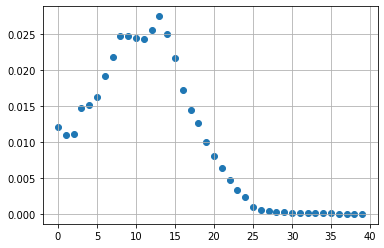

In [14]:
import matplotlib.pyplot as plt

x = list(range(40))
y1 = np.array([len(eachpos) for eachpos in reslist])/nline
plt.scatter(x, y1)	
plt.grid(True)
plt.show()	

* 한 앞에 2개 제하고나서부터 20개 bins결과를 가져와야겠다.

In [15]:
reslist_cut = reslist[2:22]

# 3. Error Frequency Graph (FigS2C)

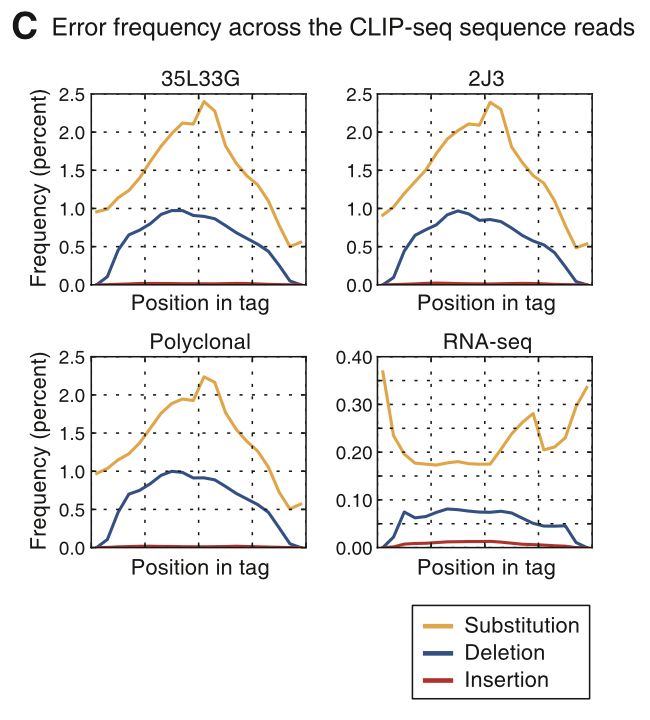

In [16]:
from PIL import Image
img1 = Image.open("../goal_myproject.png")
dim1 = (0,0,650, 720)
crop_img1 = img1.crop(dim1)
crop_img1

In [17]:
DelErrCount = [sum(1 if eacherr.startswith("^") else 0 for eacherr in errPos) \
               for errPos in reslist_cut]
SubErrCount = [sum(0 if eacherr.startswith("^") else 1 for eacherr in errPos) \
               for errPos in reslist_cut]

In [18]:
SubErrFreq =  np.array(SubErrCount)/nline
DelErrFreq =  np.array(DelErrCount)/nline

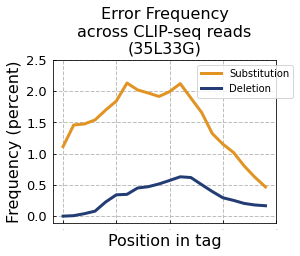

In [19]:
x = list(range(20))
y1 = SubErrFreq*100
y2 = DelErrFreq*100
plt.figure(figsize=(4,3))
plt.title("Error Frequency\nacross CLIP-seq reads\n(35L33G)", size = 16)
plt.xlabel("Position in tag", size = 16)
plt.ylabel("Frequency (percent)", size = 16)
plt.plot(x, y1, "#E19323", label= "Substitution", linewidth ="3")	
plt.plot(x, y2, "#233C74", label = "Deletion", linewidth = "3")	
plt.legend(loc = "upper right", bbox_to_anchor=(1.1,1))
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
plt.tick_params(axis='y', direction='in', length=3, pad=6, labelsize=13)
plt.tick_params(axis='x', direction='in', length=3, pad=6, labelsize=0)
plt.grid(linestyle='--',alpha = 0.8,linewidth="1")
#plt.show()
plt.savefig('errorFreq.png', bbox_inches= "tight")

* 비슷한듯 다른 그래프....이지만 일단 이대로 만족하고
* error type별로 base-specific freqeucney도 뽑아보자

# 4. Base-specific Error Frequency Graphs (FigS2D)

## 4-1. Substitution

In [20]:
!awk '{ print $3 }' CigarLenMD_plus.txt | grep -E "[0-9]+[ACTG]" | wc -l

 5030854


In [21]:
nMismatch = 5030854

In [22]:
start = time.time()
#리스트컴프리헨션, if함수, join함수 그리고 count한번에 쓰려면 시간이 영원히 걸리더라.
#그래서 일단 이렇게 나눠서 진행
SubErrlist = [[eacherr for eacherr in errPos if not eacherr.startswith("^")] \
              for errPos in reslist_cut]
DelErrlist = [[eacherr for eacherr in errPos if eacherr.startswith("^")] \
              for errPos in reslist_cut]
print(time.time()- start)

1.5283362865447998


In [23]:
start = time.time()

SubErrAcount = np.zeros(shape=(20,), dtype=np.int64)
SubErrCcount = np.zeros(shape=(20,), dtype=np.int64)
SubErrGcount = np.zeros(shape=(20,), dtype=np.int64)
SubErrTcount = np.zeros(shape=(20,), dtype=np.int64)
for i, errPos in enumerate(SubErrlist):
    SubErrAcount[i] = sum(eachErr.count("A") for eachErr in errPos)
    SubErrCcount[i] = sum(eachErr.count("C") for eachErr in errPos)
    SubErrGcount[i] = sum(eachErr.count("G") for eachErr in errPos)
    SubErrTcount[i] = sum(eachErr.count("T") for eachErr in errPos)
print("time: ", time.time() - start)

time:  2.5351150035858154


In [24]:
SubErrAfreq = SubErrAcount/nMismatch
SubErrCfreq = SubErrCcount/nMismatch
SubErrGfreq = SubErrGcount/nMismatch
SubErrTfreq = SubErrTcount/nMismatch

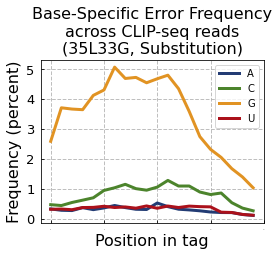

In [25]:
x = list(range(20))
y1 = SubErrAfreq*100
y2 = SubErrCfreq*100
y3 = SubErrGfreq*100
y4 = SubErrTfreq*100
plt.figure(figsize=(4,3))
plt.title("Base-Specific Error Frequency\nacross CLIP-seq reads\n(35L33G, Substitution)", size = 16)
plt.xlabel("Position in tag", size = 16)
plt.ylabel("Frequency (percent)", size = 16)
plt.plot(x, y1, "#233C74", label = "A", linewidth ="3")	
plt.plot(x, y2, "#4C842C", label = "C", linewidth ="3") 
plt.plot(x, y3, "#E19323", label = "G", linewidth ="3")
plt.plot(x, y4, "#AB111B", label = "U", linewidth ="3")
plt.legend(loc = "upper right")
plt.xticks([0, 5, 10, 15, 20])
plt.tick_params(axis='y', direction='in', length=3, pad=6, labelsize=13)
plt.tick_params(axis='x', direction='in', length=3, pad=6, labelsize=0)
plt.grid(linestyle='--',alpha = 0.8,linewidth="1")
#plt.show()
plt.savefig('BaseErrorFreq_Sub.png', bbox_inches= "tight")

# 4-2. Deletion

In [26]:
!awk '{ print $3 }' CigarLenMD_plus.txt | grep -F "^" | wc -l

 1058794


In [27]:
nDel = 1058794

In [28]:
start = time.time()
DelErrAcount = np.zeros(shape=(20,), dtype=np.int64)
DelErrCcount = np.zeros(shape=(20,), dtype=np.int64)
DelErrGcount = np.zeros(shape=(20,), dtype=np.int64)
DelErrTcount = np.zeros(shape=(20,), dtype=np.int64)
for i, errPos in enumerate(DelErrlist):
    DelErrAcount[i] = sum(eachErr.count("A") for eachErr in errPos)
    DelErrCcount[i] = sum(eachErr.count("C") for eachErr in errPos)
    DelErrGcount[i] = sum(eachErr.count("G") for eachErr in errPos)
    DelErrTcount[i] = sum(eachErr.count("T") for eachErr in errPos)
print("time: ", time.time() - start)

time:  0.7771079540252686


In [29]:
DelErrAfreq = DelErrAcount/nMismatch
DelErrCfreq = DelErrCcount/nMismatch
DelErrGfreq = DelErrGcount/nMismatch
DelErrTfreq = DelErrTcount/nMismatch

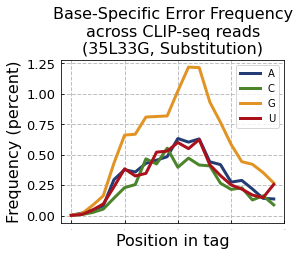

In [30]:
x = list(range(20))
y1 = DelErrAfreq*100
y2 = DelErrCfreq*100
y3 = DelErrGfreq*100
y4 = DelErrTfreq*100
plt.figure(figsize=(4,3))
plt.title("Base-Specific Error Frequency\nacross CLIP-seq reads\n(35L33G, Substitution)", size = 16)
plt.xlabel("Position in tag", size = 16)
plt.ylabel("Frequency (percent)", size = 16)
plt.plot(x, y1, "#233C74", label = "A", linewidth ="3")	
plt.plot(x, y2, "#4C842C", label = "C", linewidth ="3") 
plt.plot(x, y3, "#E19323", label = "G", linewidth ="3")
plt.plot(x, y4, "#AB111B", label = "U", linewidth ="3")
plt.legend(loc = "upper right")
plt.xticks([0, 5, 10, 15, 20])
plt.tick_params(axis='y', direction='in', length=3, pad=6, labelsize=13)
plt.tick_params(axis='x', direction='in', length=3, pad=6, labelsize=0)
plt.grid(linestyle='--',alpha = 0.8,linewidth="1")
#plt.show()
plt.savefig('BaseErrorFreq_Del.png', bbox_inches= "tight")

## Think more

* 이번에는 insertion 에러는 다루지 않고 각 error의 read상에서 postion을 파일업 할 때도 insertion은 무시하였다. 시작 포인트로 사용한 bam파일에서 Insertion error의 base정보를 알수가 없었기 때문이다. 그러나 이 insertion 어느정도로 많은지, 정말 무시해도 될 정도인지는 확인하는게 좋을 것같다.

In [31]:
!samtools view ../datapack/CLIP-35L33G.bam | cut -f 6 | grep "I" | wc -l

   80873


In [32]:
print(80873/38880853)

0.002080021238217176


* sam파일 매뉴얼에 없는 MD tag가 발견되어, 이렇게 MD가 표기된 read의 다른 정보들은 어떨지 잠깐 살펴본다.

In [33]:
!samtools view ../datapack/CLIP-35L33G.bam | grep -F "MD:Z:0CTG" | head -6

SRR458758.626397	256	chr1	4911719	0	40M	*	0	0	ACTCTCTTCCAAAGGTCCTGAGTTCAAATCCCAGCAACCA	?141>:76:=:95/-,:6?@85/?46?66?6=*-//:1/+	MD:Z:0CTG37	NH:i:67	HI:i:16	NM:i:3	SM:i:0	XQ:i:22	X2:i:40	XO:Z:UM	XS:A:+	XY:Z:+ENSMUST00000141278.2:3125..3164
SRR458758.1222986	256	chr1	4911719	0	40M	*	0	0	ACTCTCTTCCAAAGGTCCTGAGTTCAAATCCCAGCAACCA	IIIIIIHIIIIIIGIIIIIIIIIIIIIIIIIIIHEIHIHI	MD:Z:0CTG37	NH:i:67	HI:i:16	NM:i:3	SM:i:0	XQ:i:9	X2:i:40	XO:Z:UM	XS:A:+	XY:Z:+ENSMUST00000141278.2:3125..3164
SRR458758.2730793	256	chr1	4911719	0	40M	*	0	0	ACTCTCTTCCAAAGGTCCTGAGTTCAAATCCCAGCAACCA	IIIIIIIIIIIIIIIIIIIIHIIIIIIIIIIIIIIIIIII	MD:Z:0CTG37	NH:i:67	HI:i:16	NM:i:3	SM:i:0	XQ:i:9	X2:i:40	XO:Z:UM	XS:A:+	XY:Z:+ENSMUST00000141278.2:3125..3164
SRR458758.4869477	256	chr1	4911719	0	40M	*	0	0	ACTCTCTTCCAAAGGTCCTGAGTTCAAATCCCAGCAACCA	IIIHIIIIIIIIIIIHIIIIIIHIIIIIIIIIIIHIIIIH	MD:Z:0CTG37	NH:i:67	HI:i:16	NM:i:3	SM:i:0	XQ:i:9	X2:i:40	XO:Z:UM	XS:A:+	XY:Z:+ENSMUST00000141278.2:3125..3164
SRR458758.4933045	256	chr1	4911719	0	40M	*	0

* 위 결과를 보면 CIGAR가 40M이니 다른 종류의 error는 아닌 것 같다. 그리고 `MD:Z:0CTG37`이랑 `NM:i:3`을 보니까 `MD:Z:0C0T0G37`이랑 동일한 상황인거같다.
* 아니면 혹시 이 alignmnet에서는 연속으로 substitution error가 발생했을 때,`[0-9]+[ACTG]0[ACTG]`같은 식의 표현을 사용하지 않고 `[0-9]+[ACTG]+`로 표시하는 걸까 확인해봤는데 그렇지도 않다.

In [35]:
!samtools view ../datapack/CLIP-35L33G.bam | grep "MD:Z:.*[0-9][ACGT][0][ACGT]" | head -3

SRR458758.4889132	0	chr1	5163692	39	25M2121N3M2D40M	*	0	0	AACCATGGTTGACGATATGCTGCAAAAATCACCAGCGTGTCAGCATTTTCTTTGACTATGCGAAACGA	EDDBBBFFEEGGGGGGDGDGHHEHHGGDDDGDBGDECEFCBFCF>DEEGEDDDDGBEEECDDGGGDDG	MD:Z:24G0G2^AG40	NH:i:1	HI:i:1	NM:i:4	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+
SRR458758.6896959	0	chr1	5163692	39	25M2121N3M2D40M	*	0	0	AACCATGGTTGACGATATGCTGCAAAAATCACCAGCGTGTCAGCATTTTCTTTGACTATGCGAAACGA	E=?7D=EGG=HEFHBBB@HEHDHAEH@DEHHH>>HHBGHHG:GGGHHGHHDHGHHEBH@HDGFHHGHH	MD:Z:24G0G2^AG40	NH:i:1	HI:i:1	NM:i:4	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+
SRR458758.7669194	0	chr1	5163692	39	25M2121N3M2D40M	*	0	0	AACCATGGTTGACGATATGCTGCAAAAATCACCAGCGTGTCAGCATTTTCTTTGACTATGCGAAACGA	G>>DGGGGGGH@H<GEDGGDGGGFGHH@HDGE@@B<E8BEGGGGEGGGG>DGDDGGDG@DGDGGGCEF	MD:Z:24G0G2^AG40	NH:i:1	HI:i:1	NM:i:4	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+
^C
